# Embedding-Based Zero-Shot Classification

**Approach**: Prototype-based semantic similarity using sentence embeddings

This approach improves upon rule-based matching by:
1. Creating consistent input text from CV positions (title + company)
2. Embedding all texts using sentence-transformers (multilingual model)
3. Aggregating lookup table embeddings per label into **prototypes** (mean embedding)
4. Computing cosine similarity between input and all label prototypes
5. Predicting label with highest similarity score
6. Storing top-k similar labels for explainability

**Key Features**:
- **Zero-shot**: No training, pure similarity-based classification
- **Prototypes**: Each label represented by mean of all its example embeddings
- **Multilingual**: Handles German/French/English seamlessly
- **Explainability**: Top-k most similar labels with confidence scores

**Model**: `paraphrase-multilingual-MiniLM-L12-v2` (384-dimensional embeddings)

**Training Data**: Lookup tables (10,145 dept + 9,431 seniority examples) → 11 + 6 prototypes  
**Validation Data**: 478 annotated LinkedIn CVs (loaded only for evaluation)

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Import data loaders and models
import sys
sys.path.append('../')
from src.data.loader import load_label_lists, load_inference_dataset, load_evaluation_dataset
from src.models.embedding_classifier import EmbeddingClassifier, create_domain_classifier, create_seniority_classifier

# Paths
DATA_DIR = Path('../data')
RESULTS_DIR = Path('./results')
RESULTS_DIR.mkdir(exist_ok=True)

%matplotlib inline

## 1. Load Training Data (Lookup Tables)

In [2]:
# Load lookup tables
dept_df, sen_df = load_label_lists(DATA_DIR, max_per_class=None)

print(f"Department lookup: {len(dept_df):,} examples")
print(f"Seniority lookup:  {len(sen_df):,} examples")
print(f"\nUnique departments: {dept_df['label'].nunique()}")
print(f"Unique seniority levels: {sen_df['label'].nunique()}")

Applying encoding fix...
  Deduplication: 10145 -> 10145 (removed 0 duplicates)
  Deduplication: 9428 -> 9428 (removed 0 duplicates)
Department lookup: 10,145 examples
Seniority lookup:  9,428 examples

Unique departments: 11
Unique seniority levels: 5


## 2. Zero-Shot Embedding Classifier

**Approach**: Pure zero-shot classification using semantic similarity

**Key Steps**:
1. Create consistent input text from CV positions (robust handling of missing values)
2. Generate embeddings for input texts and lookup table entries
3. Aggregate lookup embeddings per label into prototypes (mean)
4. Compute cosine similarity between input and all label prototypes
5. Select label with highest similarity (optional: threshold-based fallback)
6. Store top-k similarities for explainability

**Implementation Details**:
- Model: `paraphrase-multilingual-MiniLM-L12-v2` (multilingual support)
- Caching: Store prototypes locally for faster re-runs
- Evaluation: Accuracy, macro-F1, weighted-F1, precision, recall
- Missing "Professional" seniority: Added manually (found in EDA, missing in CSV)

In [3]:
# Helper function: Create consistent input text from position data
def create_input_text(row):
    """
    Create robust input text from DataFrame row.
    Uses the 'text' column created by prepare_dataset() which combines title and company.
    
    Args:
        row: DataFrame row with CV position data
    
    Returns:
        Input text string
    """
    # The 'text' column already combines title and company
    # e.g., "Senior Engineer at Google"
    if 'text' in row and pd.notna(row['text']) and row['text'].strip():
        return row['text']
    
    # Fallback: use title only
    if 'title' in row and pd.notna(row['title']) and row['title'].strip():
        return row['title']
    
    # Last resort
    return "Unknown Position"

## 3. Build Label Prototypes with Caching

Aggregate lookup table embeddings per label into prototypes (mean embedding).
Prototypes are cached to disk for faster re-runs.

In [4]:
from sentence_transformers import SentenceTransformer
import pickle

# Cache directory
CACHE_DIR = RESULTS_DIR / 'embedding_cache'
CACHE_DIR.mkdir(exist_ok=True)

DEPT_CACHE = CACHE_DIR / 'dept_prototypes.pkl'
SEN_CACHE = CACHE_DIR / 'sen_prototypes.pkl'

# Model for embeddings
MODEL_NAME = 'paraphrase-multilingual-MiniLM-L12-v2'

print(f"Model: {MODEL_NAME}")
print(f"Cache directory: {CACHE_DIR}")
print(f"Department cache: {DEPT_CACHE.exists()}")
print(f"Seniority cache: {SEN_CACHE.exists()}")

Model: paraphrase-multilingual-MiniLM-L12-v2
Cache directory: results\embedding_cache
Department cache: True
Seniority cache: True


In [5]:
def build_label_prototypes(label_df, cache_path, model_name=MODEL_NAME, force_rebuild=False):
    """
    Build label prototypes by averaging embeddings of all examples per label.
    
    Args:
        label_df: DataFrame with 'text' and 'label' columns
        cache_path: Path to cache file
        model_name: Sentence transformer model name
        force_rebuild: If True, ignore cache and rebuild
    
    Returns:
        dict: {label: prototype_embedding}
    """
    # Check cache
    if cache_path.exists() and not force_rebuild:
        print(f"Loading prototypes from cache: {cache_path.name}")
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    
    print(f"Building prototypes (model: {model_name})...")
    model = SentenceTransformer(model_name)
    
    prototypes = {}
    labels = label_df['label'].unique()
    
    for label in labels:
        # Get all examples for this label
        examples = label_df[label_df['label'] == label]['text'].tolist()
        
        # Embed all examples
        embeddings = model.encode(examples, convert_to_numpy=True, normalize_embeddings=True, 
                                   batch_size=32, show_progress_bar=False)
        
        # Compute mean (prototype)
        prototype = np.mean(embeddings, axis=0)
        # Normalize prototype
        prototype = prototype / np.linalg.norm(prototype)
        
        prototypes[label] = prototype
        print(f"  {label}: {len(examples)} examples → prototype shape {prototype.shape}")
    
    # Save to cache
    with open(cache_path, 'wb') as f:
        pickle.dump(prototypes, f)
    print(f"Saved to cache: {cache_path.name}\n")
    
    return prototypes


# Build department prototypes
dept_prototypes = build_label_prototypes(dept_df, DEPT_CACHE)

print(f"Department prototypes: {len(dept_prototypes)} labels")

Loading prototypes from cache: dept_prototypes.pkl
Department prototypes: 11 labels


In [6]:
# Build seniority prototypes
# CRITICAL: Add missing "Professional" label (found in EDA, missing in CSV)
ALL_SENIORITY_LABELS = ['Junior', 'Professional', 'Senior', 'Lead', 'Management', 'Director']

# For missing "Professional", create synthetic examples
sen_df_extended = sen_df.copy()
professional_examples = pd.DataFrame({
    'text': ['Professional', 'Professional Position', 'Professional Role'],
    'label': ['Professional'] * 3
})
sen_df_extended = pd.concat([sen_df_extended, professional_examples], ignore_index=True)

sen_prototypes = build_label_prototypes(sen_df_extended, SEN_CACHE)

print(f"Seniority prototypes: {len(sen_prototypes)} labels")
print(f"Labels: {list(sen_prototypes.keys())}")

Loading prototypes from cache: sen_prototypes.pkl
Seniority prototypes: 6 labels
Labels: ['Junior', 'Senior', 'Lead', 'Management', 'Director', 'Professional']


In [7]:
# Load evaluation dataset
print("Loading evaluation dataset...")
eval_df = load_evaluation_dataset(DATA_DIR)

print(f"Evaluation samples: {len(eval_df)}")
print(f"Columns: {list(eval_df.columns)}")
print(f"\nSample data:")
print(eval_df[['title', 'company', 'department', 'seniority']].head(3))

Loading evaluation dataset...
Evaluation samples: 478
Columns: ['cv_id', 'title', 'company', 'text', 'department', 'seniority']

Sample data:
                     title             company              department  \
0                Prokurist   Depot4Design GmbH                   Other   
1      Solutions Architect  Computer Solutions  Information Technology   
2  Medizintechnik Beratung           Udo Weber              Consulting   

      seniority  
0    Management  
1  Professional  
2  Professional  


## 4. Zero-Shot Classification with Top-K Explainability

Compute cosine similarity between input embeddings and label prototypes.
Store top-k most similar labels for each prediction.

In [8]:
def predict_with_topk(input_text, prototypes, model, top_k=3, threshold=None):
    """
    Predict label using cosine similarity with top-k explainability.
    
    Args:
        input_text: Input text to classify
        prototypes: dict of {label: embedding}
        model: SentenceTransformer model
        top_k: Number of top similar labels to return
        threshold: Minimum similarity threshold (optional fallback)
    
    Returns:
        tuple: (predicted_label, confidence, top_k_dict)
    """
    # Embed input
    input_emb = model.encode([input_text], convert_to_numpy=True, normalize_embeddings=True)[0]
    
    # Compute similarities (cosine = dot product for normalized vectors)
    similarities = {}
    for label, prototype in prototypes.items():
        sim = np.dot(input_emb, prototype)
        similarities[label] = float(sim)
    
    # Sort by similarity
    sorted_labels = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    
    # Get prediction
    predicted_label, confidence = sorted_labels[0]
    
    # Apply threshold fallback
    if threshold and confidence < threshold:
        predicted_label = "Unknown"  # or some default
    
    # Top-k for explainability
    top_k_dict = dict(sorted_labels[:top_k])
    
    return predicted_label, confidence, top_k_dict


# Test on a few examples
print("Zero-Shot Prediction Examples:")
print("=" * 80)

model = SentenceTransformer(MODEL_NAME)

for i, row in eval_df.head(5).iterrows():
    input_text = create_input_text(row)
    
    # Department prediction
    dept_pred, dept_conf, dept_topk = predict_with_topk(input_text, dept_prototypes, model)
    
    print(f"Input: {input_text[:60]}...")
    print(f"True Department:  {row['department']}")
    print(f"Predicted:        {dept_pred} (confidence: {dept_conf:.3f})")
    print(f"Top-3:            {', '.join([f'{k}: {v:.3f}' for k, v in list(dept_topk.items())[:3]])}")
    print()

Zero-Shot Prediction Examples:
Input: Prokurist at Depot4Design GmbH...
True Department:  Other
Predicted:        Consulting (confidence: 0.538)
Top-3:            Consulting: 0.538, Information Technology: 0.520, Sales: 0.506

Input: Solutions Architect at Computer Solutions...
True Department:  Information Technology
Predicted:        Project Management (confidence: 0.575)
Top-3:            Project Management: 0.575, Information Technology: 0.543, Customer Support: 0.522

Input: Medizintechnik Beratung at Udo Weber...
True Department:  Consulting
Predicted:        Consulting (confidence: 0.517)
Top-3:            Consulting: 0.517, Administrative: 0.440, Information Technology: 0.404

Input: Director expansión de negocio. at Grupo Viajes Kontiki....
True Department:  Business Development
Predicted:        Business Development (confidence: 0.684)
Top-3:            Business Development: 0.684, Sales: 0.639, Administrative: 0.627

Input: APL-ansvarig, samordning at Himmelstalunds Utbildni

## 5. Full Evaluation on Annotated Dataset

Predict all samples and compute comprehensive metrics.

In [9]:
# Create input texts for all evaluation samples
print("Creating input texts for all samples...")
eval_df['input_text'] = eval_df.apply(create_input_text, axis=1)

print(f"Total samples: {len(eval_df)}")
print(f"Sample input text: {eval_df['input_text'].iloc[0][:100]}...")

Creating input texts for all samples...
Total samples: 478
Sample input text: Prokurist at Depot4Design GmbH...


### 5.1 Department Classification

In [10]:
# Predict all departments with top-k tracking
print("Predicting departments for all samples...")

dept_predictions = []
dept_confidences = []
dept_topk_all = []

for _, row in eval_df.iterrows():
    pred, conf, topk = predict_with_topk(row['input_text'], dept_prototypes, model, top_k=3)
    dept_predictions.append(pred)
    dept_confidences.append(conf)
    dept_topk_all.append(topk)

eval_df['dept_pred'] = dept_predictions
eval_df['dept_conf'] = dept_confidences
eval_df['dept_topk'] = dept_topk_all

# Compute metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

dept_true = eval_df['department'].tolist()
dept_pred = eval_df['dept_pred'].tolist()

dept_accuracy = accuracy_score(dept_true, dept_pred)
dept_precision, dept_recall, dept_f1, _ = precision_recall_fscore_support(
    dept_true, dept_pred, average='macro', zero_division=0
)
_, _, dept_f1_weighted, _ = precision_recall_fscore_support(
    dept_true, dept_pred, average='weighted', zero_division=0
)

print("=" * 60)
print("DEPARTMENT CLASSIFICATION RESULTS")
print("=" * 60)
print(f"Accuracy:          {dept_accuracy:.4f}")
print(f"Precision (macro): {dept_precision:.4f}")
print(f"Recall (macro):    {dept_recall:.4f}")
print(f"F1-score (macro):  {dept_f1:.4f}")
print(f"F1-score (wtd):    {dept_f1_weighted:.4f}")
print("=" * 60)

Predicting departments for all samples...
DEPARTMENT CLASSIFICATION RESULTS
Accuracy:          0.3243
Precision (macro): 0.3643
Recall (macro):    0.4449
F1-score (macro):  0.3442
F1-score (wtd):    0.3341


In [11]:
# Detailed classification report
print("\nDetailed Classification Report (Department):")
print(classification_report(dept_true, dept_pred, zero_division=0))


Detailed Classification Report (Department):
                        precision    recall  f1-score   support

        Administrative       0.09      0.56      0.16         9
  Business Development       0.17      0.35      0.23        17
            Consulting       0.20      0.68      0.31        28
      Customer Support       0.14      0.33      0.20         6
       Human Resources       0.53      0.53      0.53        15
Information Technology       0.48      0.27      0.35        55
             Marketing       0.44      0.39      0.41        18
                 Other       0.75      0.20      0.32       250
    Project Management       0.29      0.48      0.36        31
            Purchasing       0.67      0.50      0.57        12
                 Sales       0.25      0.59      0.35        37

              accuracy                           0.32       478
             macro avg       0.36      0.44      0.34       478
          weighted avg       0.56      0.32      0.33   

### 5.2 Seniority Classification

In [12]:
# Predict all seniority levels with top-k tracking
print("Predicting seniority for all samples...")

sen_predictions = []
sen_confidences = []
sen_topk_all = []

for _, row in eval_df.iterrows():
    pred, conf, topk = predict_with_topk(row['input_text'], sen_prototypes, model, top_k=3)
    sen_predictions.append(pred)
    sen_confidences.append(conf)
    sen_topk_all.append(topk)

eval_df['sen_pred'] = sen_predictions
eval_df['sen_conf'] = sen_confidences
eval_df['sen_topk'] = sen_topk_all

# Compute metrics
sen_true = eval_df['seniority'].tolist()
sen_pred = eval_df['sen_pred'].tolist()

sen_accuracy = accuracy_score(sen_true, sen_pred)
sen_precision, sen_recall, sen_f1, _ = precision_recall_fscore_support(
    sen_true, sen_pred, average='macro', zero_division=0
)
_, _, sen_f1_weighted, _ = precision_recall_fscore_support(
    sen_true, sen_pred, average='weighted', zero_division=0
)

print("=" * 60)
print("SENIORITY CLASSIFICATION RESULTS")
print("=" * 60)
print(f"Accuracy:          {sen_accuracy:.4f}")
print(f"Precision (macro): {sen_precision:.4f}")
print(f"Recall (macro):    {sen_recall:.4f}")
print(f"F1-score (macro):  {sen_f1:.4f}")
print(f"F1-score (wtd):    {sen_f1_weighted:.4f}")
print("=" * 60)

Predicting seniority for all samples...
SENIORITY CLASSIFICATION RESULTS
Accuracy:          0.4205
Precision (macro): 0.4213
Recall (macro):    0.4298
F1-score (macro):  0.3613
F1-score (wtd):    0.4314


In [13]:
# Detailed classification report
print("\nDetailed Classification Report (Seniority):")
print(classification_report(sen_true, sen_pred, zero_division=0))


Detailed Classification Report (Seniority):
              precision    recall  f1-score   support

    Director       0.39      0.41      0.40        27
      Junior       0.06      0.40      0.10        10
        Lead       0.48      0.48      0.48       103
  Management       0.65      0.67      0.66       138
Professional       0.77      0.17      0.28       161
      Senior       0.18      0.46      0.26        39

    accuracy                           0.42       478
   macro avg       0.42      0.43      0.36       478
weighted avg       0.59      0.42      0.43       478



## 6. Error Analysis with Top-K Explainability

Analyze misclassifications with top-k similar labels to understand failure modes.

In [14]:
# Department errors with top-k explainability
dept_errors = eval_df[eval_df['department'] != eval_df['dept_pred']].copy()

print(f"Department Misclassifications: {len(dept_errors)} / {len(eval_df)} ({len(dept_errors)/len(eval_df)*100:.1f}%)")
print("\nTop 10 Department Errors with Top-3 Similarities:")
print("=" * 100)

for idx, row in dept_errors.head(10).iterrows():
    print(f"\nInput: {row['input_text'][:70]}...")
    print(f"True:      {row['department']}")
    print(f"Predicted: {row['dept_pred']} (conf: {row['dept_conf']:.3f})")
    print(f"Top-3:     {', '.join([f'{k}: {v:.3f}' for k, v in list(row['dept_topk'].items())[:3]])}")
    
    # Check if true label is in top-3
    true_in_topk = row['department'] in row['dept_topk']
    if true_in_topk:
        true_rank = list(row['dept_topk'].keys()).index(row['department']) + 1
        true_sim = row['dept_topk'][row['department']]
        print(f"           [True label '{row['department']}' is rank #{true_rank} with similarity {true_sim:.3f}]")

Department Misclassifications: 323 / 478 (67.6%)

Top 10 Department Errors with Top-3 Similarities:

Input: Prokurist at Depot4Design GmbH...
True:      Other
Predicted: Consulting (conf: 0.538)
Top-3:     Consulting: 0.538, Information Technology: 0.520, Sales: 0.506

Input: Solutions Architect at Computer Solutions...
True:      Information Technology
Predicted: Project Management (conf: 0.575)
Top-3:     Project Management: 0.575, Information Technology: 0.543, Customer Support: 0.522
           [True label 'Information Technology' is rank #2 with similarity 0.543]

Input: Lab-Supervisor at MacDermid Enthone Industrial Solutions...
True:      Other
Predicted: Consulting (conf: 0.579)
Top-3:     Consulting: 0.579, Information Technology: 0.569, Project Management: 0.540

Input: Set Lighting at Twentieth Century Fox...
True:      Other
Predicted: Project Management (conf: 0.156)
Top-3:     Project Management: 0.156, Information Technology: 0.155, Consulting: 0.154

Input: Projektmanag

# Seniority errors with top-k explainability
sen_errors = eval_df[eval_df['seniority'] != eval_df['sen_pred']].copy()

print(f"Seniority Misclassifications: {len(sen_errors)} / {len(eval_df)} ({len(sen_errors)/len(eval_df)*100:.1f}%)")
print("\nTop 10 Seniority Errors with Top-3 Similarities:")
print("=" * 100)

for idx, row in sen_errors.head(10).iterrows():
    print(f"\nInput: {row['input_text'][:70]}...")
    print(f"True:      {row['seniority']}")
    print(f"Predicted: {row['sen_pred']} (conf: {row['sen_conf']:.3f})")
    print(f"Top-3:     {', '.join([f'{k}: {v:.3f}' for k, v in list(row['sen_topk'].items())[:3]])}")
    
    # Check if true label is in top-3
    true_in_topk = row['seniority'] in row['sen_topk']
    if true_in_topk:
        true_rank = list(row['sen_topk'].keys()).index(row['seniority']) + 1
        true_sim = row['sen_topk'][row['seniority']]
        print(f"           [True label '{row['seniority']}' is rank #{true_rank} with similarity {true_sim:.3f}]")

## 7. Confidence Distribution Analysis

Analyze prediction confidence to identify uncertain predictions.

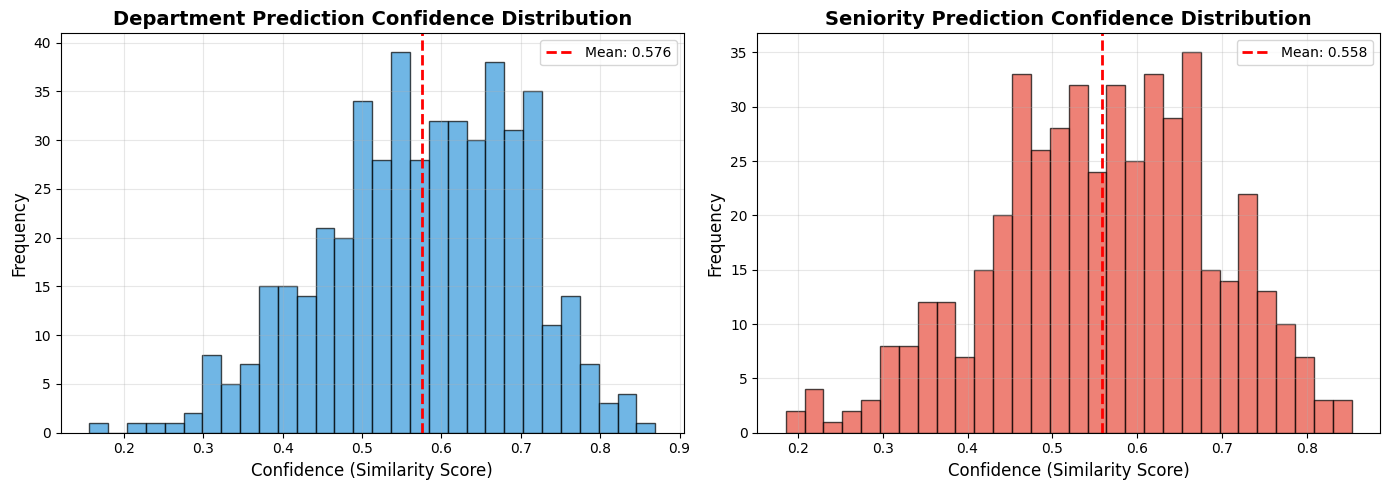


Low Confidence Predictions (confidence < 0.3):
Department: 6 samples
Seniority:  12 samples

Example low-confidence department predictions:
  Input: Set Lighting at Twentieth Century Fox...
  Pred:  Project Management (conf: 0.156)
  Top-3: Project Management: 0.156, Information Technology: 0.155, Consulting: 0.154

  Input: Physiotherapeutin at TZ Garsten...
  Pred:  Consulting (conf: 0.255)
  Top-3: Consulting: 0.255, Administrative: 0.199, Customer Support: 0.167

  Input: Head of Marketing: Promoting label-free cell analysis techno...
  Pred:  Marketing (conf: 0.297)
  Top-3: Marketing: 0.297, Information Technology: 0.274, Sales: 0.272



In [15]:
# Confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Department confidence
axes[0].hist(eval_df['dept_conf'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
axes[0].axvline(eval_df['dept_conf'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {eval_df["dept_conf"].mean():.3f}')
axes[0].set_xlabel('Confidence (Similarity Score)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Department Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Seniority confidence
axes[1].hist(eval_df['sen_conf'], bins=30, edgecolor='black', alpha=0.7, color='#e74c3c')
axes[1].axvline(eval_df['sen_conf'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {eval_df["sen_conf"].mean():.3f}')
axes[1].set_xlabel('Confidence (Similarity Score)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Seniority Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/embedding_confidence_dist.png', dpi=150)
plt.show()

# Low confidence samples
print("\nLow Confidence Predictions (confidence < 0.3):")
print("=" * 100)

low_conf_dept = eval_df[eval_df['dept_conf'] < 0.3]
low_conf_sen = eval_df[eval_df['sen_conf'] < 0.3]

print(f"Department: {len(low_conf_dept)} samples")
print(f"Seniority:  {len(low_conf_sen)} samples")

if len(low_conf_dept) > 0:
    print("\nExample low-confidence department predictions:")
    for idx, row in low_conf_dept.head(3).iterrows():
        print(f"  Input: {row['input_text'][:60]}...")
        print(f"  Pred:  {row['dept_pred']} (conf: {row['dept_conf']:.3f})")
        print(f"  Top-3: {', '.join([f'{k}: {v:.3f}' for k, v in list(row['dept_topk'].items())[:3]])}")
        print()

## 8. Save Results

Save predictions and metrics for comparison with other approaches.

In [21]:
# Save results to JSON
results = {
    'approach': 'embedding_zero_shot',
    'model': MODEL_NAME,
    'timestamp': datetime.now().isoformat(),
    'department': {
        'accuracy': float(dept_accuracy),
        'precision_macro': float(dept_precision),
        'recall_macro': float(dept_recall),
        'f1_macro': float(dept_f1),
        'f1_weighted': float(dept_f1_weighted),
        'avg_confidence': float(eval_df['dept_conf'].mean()),
        'low_confidence_count': int(len(low_conf_dept))
    },
    'seniority': {
        'accuracy': float(sen_accuracy),
        'precision_macro': float(sen_precision),
        'recall_macro': float(sen_recall),
        'f1_macro': float(sen_f1),
        'f1_weighted': float(sen_f1_weighted),
        'avg_confidence': float(eval_df['sen_conf'].mean()),
        'low_confidence_count': int(len(low_conf_sen))
    },
    'notes': 'Pure zero-shot with prototype aggregation. Added missing Professional seniority level.'
}

output_path = RESULTS_DIR / 'embedding_zeroshot_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print("\n" + "="*80)
print("Real-World (Annotated LinkedIn CVs):")
print("-" * 80)
print(f"Department Accuracy:       {dept_accuracy:.3f}")
print(f"Department F1 (macro):     {dept_f1:.3f}")
print(f"Department F1 (weighted):  {dept_f1_weighted:.3f}")
print()
print(f"Seniority Accuracy:        {sen_accuracy:.3f}")
print(f"Seniority F1 (macro):      {sen_f1:.3f}")
print(f"Seniority F1 (weighted):   {sen_f1_weighted:.3f}")
print("=" * 80)


Real-World (Annotated LinkedIn CVs):
--------------------------------------------------------------------------------
Department Accuracy:       0.324
Department F1 (macro):     0.344
Department F1 (weighted):  0.334

Seniority Accuracy:        0.421
Seniority F1 (macro):      0.361
Seniority F1 (weighted):   0.431
